# N body simulation

### Background theory

From Newton's first law $F_{net}=\Sigma_ima$ we find the acceleration of particle $i$ at position $r_i$ and time t to be

$\frac{d^2 \vec{r_i}}{dt^2} = \Sigma_{j\neq i} \frac{G m_j}{\vert \vec{r_i} - \vec{r_j} \vert ^3} (\vec{r_i}-\vec{r_j})$

This equation is plagued by extremely small  and large numbers e.g. ($G \approx 6.67 \times 10^{-11}$), which do not work well with the limmited precision of floating point numbers. So strive to put equaiton into dimensionless form, such that the constants take on smaller values.

$\vec{r}' \equiv \frac{\vec{r}}{L}$, $m' \equiv \frac{m}{M}$, and $t'\equiv \frac{t}{\tau}$;

where $L$ is the charactersitic length scale (e.g 1AU for solar system simulations, 10lpc for galaxy simulations), $M$ is the characteristic mass scale (e.g. $M_{sun}$ for solar system), and $\tau$ is the time scale (units of time, e.g. 1 million years for galaxy formation simulation). The one free parameter is $\tau$ which we can choose to be such that it cancels the other parameters with dimensions in the problem. We find a convenient value of the parameter by plugging these values into the DE and setting the dimesnionless group equal to 1.

$\frac{d^2 (\vec{r_i}' L)}{d(\tau \space t')^2} = \Sigma_{j\neq i} \frac{G \space (m_j' M)}{\vert \vec{r_i}' L - \vec{r_j}' L \vert ^3} (\vec{r_i}' L-\vec{r_j}' L)$
$\implies$
$\frac{L^3}{G M \tau ^3}\frac{d^2 (\vec{r_i}')}{d(\space t')^2} = \Sigma_{j\neq i} \frac{m_j'}{\vert \vec{r_i}' - \vec{r_j}'\vert ^3} (\vec{r_i}' -\vec{r_j}')$

Identifying the dimensionless group $\frac{L^3}{G M \tau ^2}$, and setting equal to one we get $\tau = \sqrt{\frac{L^3}{G M}}$. Using this time scale, and making the substitutions 

$\vec{r} \leftarrow \frac{\vec{r}}{L}$, $m \leftarrow \frac{m}{M}$, and $t \leftarrow t \sqrt{\frac{L^3}{G M}}$, we obtain the dimensionless form of the equation 

$$\frac{d^2 \vec{r_i}}{dt^2} = \Sigma_{j\neq i} \frac{m_j}{\vert \vec{r_i} - \vec{r_j} \vert ^3} (\vec{r_i}-\vec{r_j})$$

where the mass and length scales are to be chosen appropriately for a given problem, such that the lengths and masses are of order 1. Once the simulation is run, we can find the actual lengths, times, and masses at the end by plugging values back into the defining equations of the dimensionless variables. This reduces numerical errors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

## N body simulator

In [2]:
def find_acceleration(position, mass, dt=0.01, softening = 0.0):
    """
    Get acceleration of each particle in a N particle system at a given time
    
        Args:
            position (array): Nx3 array of particle positions
            mass (array): Nx1 array of particle masses
            dt (float, optional): Time step used, controls precision, in dimensionless units
            softening (float, optional): When particles get too close together simulator quickly loses
            accuracy and singularities can occur. Making non-zero softening can prevent this, although 
            the accuracy of the program will change for other values aswell.
        
        Returns:
            a (array): Nx3 array of acceleration vectors  
    """
    

    N = position.shape[0]
    
    # Get pairwise displacement from between each particle
    displacement = position - position.reshape(N, 1, 3)
    
    # Remove displacement of particle with itself
    zero = np.all((displacement==0), axis=2)
    displacement[zero] = np.nan
    
    # Inverse distance cubed 
    inv_dist_cubed = ((np.sum(displacement**2, axis=2)+softening**2) ** -1.5).reshape(N, N, 1)
    
    # Acceleration vectors for each component
    acc_vec = displacement * inv_dist_cubed * mass.reshape(1,N,1)
    
    # Resultant acceleration vectors
    acceleration = np.nansum(acc_vec, axis=1)
    
    return acceleration

def integrator(initial_position, initial_velocity, mass, time, dt=0.01, softening = 0.0, VELOCITY=False):
    """
    Calculates the position, velocity, and acceleration of each particle at all points after t=0 
    to a given time
    
        Args:
            initial_position (array): Nx3 array of particle positions at t=0
            initial_velcity (array): Nx3 array of particle velocities at t=0
            mass (array): Nx1 array of particle masses
            time (float): Time (in dimensionless form) to run simulation for
            dt (float, optional): Time step used, controls precision, in dimensionless units of time
            softening (float, optional): softening factor
            VELOCITY (boolean, optional): If true, also return array of particle velocites for all time
        Returns:
            position (array): Nx3 array of particle positions at the end of simulation
    TODO: Implement Runge-Kutta, instead of Eulers method. Could also use Scipy.integrate instead
    """
    
    # Number of time steps
    N = int(time / dt)
    
    # Array containing path traced by particles
    n = initial_position.shape[0]                 # Number of particles in simulation
    dimensions = 3                                # Number of spatial dimesnions (x,y,z)
    positions = np.zeros((N, n, dimensions))
    velocities = np.zeros((N, n, dimensions))

    
    # Initialising particle position and velocity
    position = initial_position
    velocity = initial_velocity
    
    acceleration = find_acceleration(position, mass, dt, softening)
    
    for i in range(N):
        # Update positions, velocities, and acclerations, using leapfrog integration method
        velocity += 0.5 * acceleration * dt
        position += velocity * dt
        
        acceleration = find_acceleration(position, mass)
        velocity += 0.5 * acceleration * dt
        
        # Store in a array for plotting
        positions[i] += position
        velocities[i] += velocity
        
    if VELOCITY:
        return positions, velocities
    return positions

## Animation and plotting

In [3]:
def animate(positions, title=None, init_pos=False, final_pos=True):
    """
    Create plot of paths traced by particles in 3D space
    TODO: Make into animation rather than static image, and make it look better
    """
    # Number of particles in simulation
    N = positions.shape[1]
    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    # Colour each particle a different colour
    colour = plt.cm.get_cmap("hsv", N)

    
    for i in range(N):
        
        particle_i = positions[:, i]
        
        # Plot initial position with dashed point
        if init_pos:
            plt.plot(particle_i[0,0], particle_i[0,1], particle_i[0,2],
                marker="o", markersize=5.2, markerfacecolor='none', markeredgecolor="black")
        
        # Plot dot to show where the particle ended
        if final_pos:
            plt.plot(particle_i[-1,0], particle_i[-1,1], particle_i[-1,2],
                marker="o", markersize=5, color=colour(i))
        
        # Plot path traced by each body
        plt.plot(particle_i[1:,0], particle_i[1:,1], particle_i[1:,2], color=colour(i))
        
    
    
    ax.set_xlabel('x (AU)')
    ax.set_ylabel('y (AU)')
    ax.set_zlabel('z (AU)')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"{N} body simulation")
    

def animate_2D(positions, title=None, init_pos=False, final_pos=True):
    """Plot paths traced by particles in 2D, i.e. ignore z axis"""
    N = positions.shape[1]
    
    colour = plt.cm.get_cmap("hsv", N)
    
    for i in range(N):
        particle_i = positions[:, i]
        
        if init_pos:
            plt.plot(particle_i[0,0], particle_i[0,1],
                marker="o", markersize=5.2, markerfacecolor='none', markeredgecolor="black")
        if final_pos:
            plt.plot(particle_i[-1,0], particle_i[-1,1],
                marker="o", markersize=5, color=colour(i))
        
        plt.plot(particle_i[1:,0], particle_i[1:,1], color=colour(i))
        

    
    plt.xlabel('x (AU)')
    plt.ylabel('y (AU)')
    
    if title:
        plt.title(title)
    else:
        plt.title(f"{N} body simlation - xy axis projection")

## Time scale

In [4]:
def real_time(t, M=1.99e30, L=1.50e11, years=True):
    """Get actual time, in years. By default, use mass scale 1AU, and length scale 1 solar mass - 
       meaning all particle coordinates and mass should be given in terms of these length and 
       time sacles
    """
    G = 6.67e-11
    yr = 60 * 60 * 24 * 365.25
    tau = np.sqrt(L**3 / (G*M))
    t *= tau
    
    if years:
        t /= yr
    return t

## Track total energy - to check for leakage
Conservation of energy should hold for any system. So to check the accuracy of program, we should measure the total energy of the system (KE + PE) at each time-step to check that conservation of energy holds. If the total energy changes it is called "leakage" and indicates the system is no longer beiing accurately described by the program.

In [5]:
def get_E(mass, position, velocity):
    """
    Return the total potential energy of the system at a given time
    """
    
    KE = 0.5 * np.sum(mass * np.sum(velocity**2, axis=1))
    
    N = position.shape[0]
    
    # Get pairwise displacement from between each particle
    displacement = position - position.reshape(N, 1, 3)
    
    # Remove displacement of particle with itself
    zero = np.all((displacement==0), axis=2)
    displacement[zero] = np.nan
    
    # Inverse distance 
    dist = np.sqrt(np.sum(displacement**2, axis=2)).reshape(N, N, 1)

    
    # Half since it counts each interaction twice
    mass_prod = np.outer(mass, mass).reshape(N,N,1)
    PE = 0.5 * np.nansum(-mass_prod / dist)
    
    return KE, PE, PE + KE


def E_plot(mass, positions, velocities, title="", time = 1):
    E_arr = np.array([get_E(mass, pos, vel) for pos, vel in list(zip(positions, velocities))])
    KE, PE, E = E_arr[:,0], E_arr[:,1], E_arr[:,2]
    
    # Time scale
    tEnd = 1/real_time(time)
    t = np.linspace(0, tEnd, num=len(E))
    
    plt.plot(t, KE, label="KE")
    plt.plot(t, PE, label="PE")
    plt.plot(t, E, label="Total E")
    plt.xlabel("Time [years]")
    plt.ylabel("Energy [Scaled units]")
    plt.legend()
    plt.title(title)

### Planetary orbits

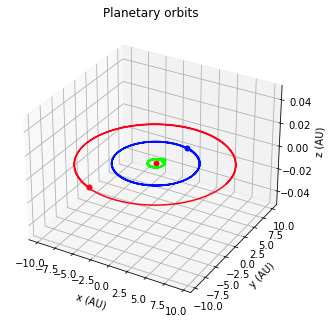

In [6]:
AU = 1.496e8                  # Astronomical units in km
s = real_time(1, years=False) # Scaled time in seconds
v_factor = (1 / AU) * s

sun_pos = np.array([0.0, 0, 0])
sun_init_v = np.array([0.0,0.0,0.0]) * v_factor
sun_mass = 1.0

earth_pos = np.array([1.0, 0, 0])
earth_init_v = np.array([0.0, 29.8, 0.0]) * v_factor
earth_mass = 1 / 330000

jupyter_pos = np.array([5.203, 0.0, 0.0])
jupyter_init_v = np.array([0.0, 13.1, 0]) * v_factor
jupyter_mass = 0.000955

saturn_pos = np.array([9.539, 0.0, 0.0])
saturn_init_v = np.array([0, 9.7, 0]) * v_factor
saturn_mass = 0.000286

init_pos = np.array([sun_pos, earth_pos, jupyter_pos, saturn_pos])
init_vel = np.array([sun_init_v, earth_init_v, jupyter_init_v, saturn_init_v])
mass = np.array([sun_mass, earth_mass, jupyter_mass, saturn_mass])


tEnd = real_time(2000)

positions = integrator(init_pos, init_vel, mass, tEnd, dt=0.01)
animate(positions, title="Planetary orbits")


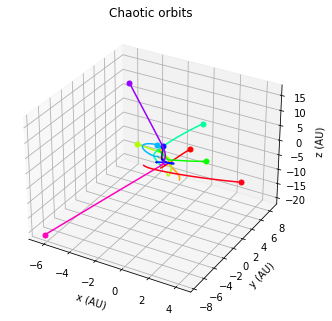

In [7]:
N = 10
# Generate Initial Conditions
np.random.seed(2)            # set the random number generator seed

mass = 10.0*np.ones((N,1))/N  # total mass of particles is 20
pos  = np.random.randn(N,3)   # randomly selected positions and velocities
vel  = np.random.randn(N,3)

positions = integrator(pos, vel, mass, 5, softening=0.0)
animate(positions, title="Chaotic orbits")

### Figure 8

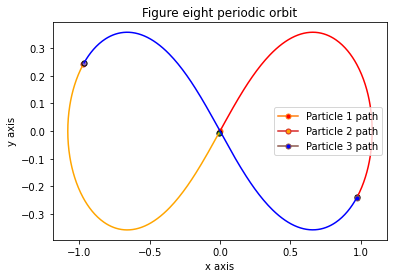

In [8]:
p1 = np.array([0.97000436, -0.24308753, 0])
v1 = np.array([0.4662036850, 0.4323657300, 0])

p2 = np.array([0, 0, 0])
v2 = np.array([-0.93240737, -0.86473146, 0])

p3 = np.array([-0.97000436, 0.24308753, 0])
v3 = np.array([0.4662036850, 0.4323657300, 0])

mass = np.array([1.0, 1.0, 1.0])

pos = np.array([p1, p2, p3])
vel = np.array([v1, v2, v3])

positions, velocities = integrator(pos, vel, mass, 2.112, VELOCITY=True)

particle0 = positions[:,0]
particle1 = positions[:,1]
particle2 = positions[:,2]

plt.plot(particle0[0,0], particle0[0,1], marker="o", markersize=5.2, markeredgecolor="black")
plt.plot(particle0[-1,0], particle0[-1,1], marker="o", markersize=5, markerfacecolor='red', label="Particle 1 path")
plt.plot(particle0[:,0], particle0[:,1], color='red')

plt.plot(particle1[0,0], particle1[0,1], marker="o", markersize=5.2, markeredgecolor="black")
plt.plot(particle1[-1,0], particle1[-1,1], marker="o", markersize=5, markerfacecolor='orange', label="Particle 2 path")
plt.plot(particle1[:,0], particle1[:,1], color='orange')

plt.plot(particle2[0,0], particle2[0,1], marker="o", markersize=5.2, markeredgecolor="black")
plt.plot(particle2[-1,0], particle2[-1,1], marker="o", markersize=5, markerfacecolor='blue', label="Particle 3 path")
plt.plot(particle2[:,0], particle2[:,1], color='blue')

plt.title("Figure eight periodic orbit")
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.legend(loc="center right")

### Many body simulations -  Chaos

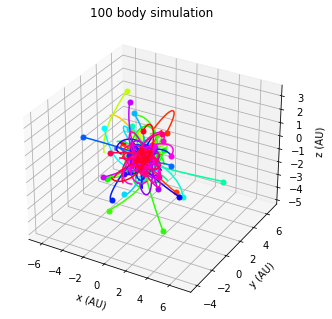

In [9]:
# Simulation parameters
N         = 100    # Number of particles
t         = 0      # current time of the simulation
tEnd      = 3.0   # time at which simulation ends
dt        = 0.01   # timestep
softening = 0.1    # softening length
G         = 1.0    # Newton's Gravitational Constant
plotRealTime = False # switch on for plotting as the simulation goes along

# Generate Initial Conditions
np.random.seed(17)            # set the random number generator seed

mass = 20.0*np.ones(N)/N  # total mass of particles is 20
pos  = np.random.randn(N,3)   # randomly selected positions and velocities
vel  = np.random.randn(N,3)

positions, velocities = integrator(pos, vel, mass, tEnd, VELOCITY=True, softening=0, dt=0.0001)

animate(positions)

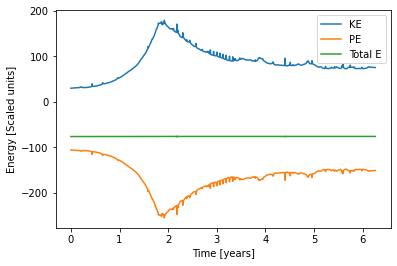

In [10]:
E_plot(mass, positions, velocities)

## Dynamical friction

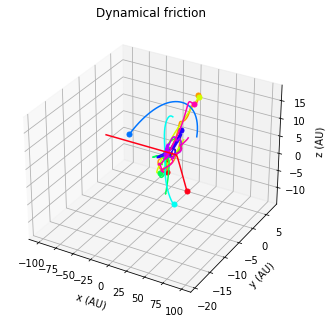

In [11]:
# Simulation parameters
N         = 10    # Number of particles
tEnd      = 20.0   # time at which simulation ends
# softening = 0.1    # softening length

# Generate Initial Conditions
np.random.seed(10)            # set the random number generator seed

mass = np.random.rand(N) * 11
pos = np.random.randn(N,3) * 4  # randomly selected positions and velocities
vel = np.random.randn(N,3) * 1

# Add in heavy incoming particle
mass = np.append(mass, 10)
pos = np.append(pos, [[-100.,0,0]], axis=0)
vel = np.append(vel, [[10, 0, 0]], axis=0)

positions, velocities = integrator(pos, vel, mass, tEnd, VELOCITY=True, softening=0., dt=0.001)

animate(positions, title="Dynamical friction")

# plt.savefig('test.png', bbox_inches='tight')



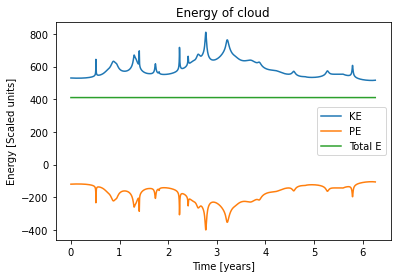

In [12]:
E_plot(mass, positions[::10], velocities[::10], title="Energy of cloud")

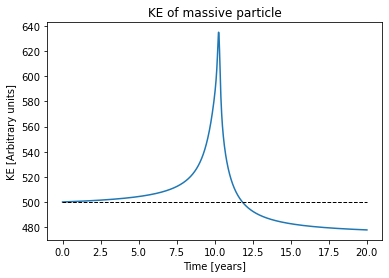

In [13]:
incoming_particle_mass = mass[-1]
incoming_particle_pos = positions[:,-1,:][::10]
incoming_particle_vel = velocities[:,-1,:][::10]
# E_plot(np.array([incoming_particle_mass]), np.array([incoming_particle_pos]), 
#     np.array([incoming_particle_vel]))

KE_incoming = [0.5 * np.sum(incoming_particle_mass * np.sum(v**2)) for v in incoming_particle_vel]
t = np.linspace(0, tEnd, num=len(KE_incoming))
plt.plot(t, KE_incoming)
plt.title("KE of massive particle")
plt.xlabel("Time [years]")
plt.ylabel("KE [Arbitrary units]")
plt.axhline(y=500, xmin=0.045, xmax=0.956, linewidth = 1, linestyle='--', color='k')


# Trojans

### Finding Lagrange points L4 and L5

In [14]:
def lagrange_evolution(planet_pos, L_type="L5"):
    """Find position of (stable) Lagrange points, given central body (Sun)
        is at coordinate (0,0,0) and orbiting body (Jupiter) is orbiting in the xy plane"""
    # 60 degree anticlockwise rotation in xy plane
    rotation_matrix = np.array([[1/2, -np.sqrt(3)/2, 0], [np.sqrt(3)/2, 1/2, 0], [0, 0, 1]])
    
    if L_type != "L5":
        if L_type == "L4":
            # Invert rotation matrix, to give 60 degree clockwise rotation of L4
            rotation_matrix = np.linalg.inv(rotation_matrix)
        else:
            raise("Need to pick L_type of 'L4' or 'L5'.")
    
    L_pos = rotation_matrix @ planet_pos.T
    
    return L_pos


### Plotting orbit of Trojans

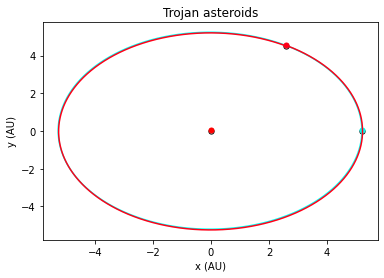

In [15]:
AU = 1.496e8                  # Astronomical units in km
s = real_time(1, years=False) # Scaled time in seconds
v_factor = (1 / AU) * s       # Factor to convert from km/s to scaled velocity

orb_r = 5.2                         # Oribtal radii of Jupiter
# orb_p = orb_r ** 1.5                # Orbital period, from Keplers law
# orb_v = 2 * np.pi * orb_r / orb_p   # Orbital velocity (assuiming circular orbit)
orb_v = 13.06
orb_v *= v_factor


sun_pos = np.array([0.0, 0, 0])
sun_init_v = np.array([0.0,0.0,0.0])
sun_mass = 1.0

jupiter_pos = np.array([orb_r, 0.0, 0.0])
jupiter_init_v = np.array([0.0, orb_v, 0])
jupiter_mass = 0.000955


L5_pos = lagrange_evolution(jupiter_pos)
L5_init_v = lagrange_evolution(jupiter_init_v)
L5_trojan_m = 1e-10

L4_pos = lagrange_evolution(jupiter_pos, L_type="L4")
L4_init_v = lagrange_evolution(jupiter_init_v, L_type="L4")
L4_trojan_m = 1e-10


init_pos = np.array([sun_pos, jupiter_pos, L5_pos])
init_vel = np.array([sun_init_v, jupiter_init_v, L5_init_v])
mass = np.array([sun_mass, jupiter_mass, L5_trojan_m])


tEnd = real_time(11.78*40)*1

positions, velocities = integrator(init_pos, init_vel, mass, tEnd, dt=0.01, VELOCITY=True)
animate_2D(positions, title="Trojan asteroids", init_pos=True)

### Finding maximum seperation

In [16]:
def seperation(positions):
    # Position of orbiting body (Jupiter) over time
    orbiting_body = positions[:,1,:]
    
    # Position of L4 Lagrange point at over time (calculated from positions of orbiting body)
    L4 = np.array([lagrange_evolution(pos) for pos in orbiting_body])
    
    # Position of Trojan, that begins near L4 Lagrange point
    trojan = positions[:,2,:]
    
    # Maximum distance between Trojan and L4 point throughout orbit
    dist = np.sqrt(np.max(np.sum((trojan - L4)**2, axis=1)))

    return dist

In [17]:
planet_masses = np.geomspace(0.5*1e-4, 0.01, 10)

sun_pos = jupiter_mass * np.array([-orb_r, 0, 0])
sun_init_v = jupiter_mass * np.array([0.0,-orb_v,0.0])
sun_mass = 1.0

jupiter_pos = np.array([orb_r, 0.0, 0.0])
jupiter_init_v = np.array([0.0, orb_v, 0])
jupiter_mass = 0.000955

L5_pos = lagrange_evolution(jupiter_pos)
L5_init_v = lagrange_evolution(jupiter_init_v)
L5_trojan_m = 1e-10


seperation_dist = []

for m in planet_masses:
    init_pos = np.array([(m/jupiter_mass) * sun_pos, jupiter_pos, L5_pos])
    init_vel = np.array([(m/jupiter_mass) * sun_init_v, jupiter_init_v, L5_init_v])
    mass = np.array([sun_mass, m, L5_trojan_m])
    
    tEnd = real_time(11.78*40)*10
    
    positions = integrator(init_pos, init_vel, mass, tEnd, dt=0.01)

    seperation_dist.append([m, seperation(positions)])

seperation_dist = np.array(seperation_dist)

In [18]:
from scipy.optimize import curve_fit

r = seperation_dist[:,0] # Mass ratio
s = seperation_dist[:,1] # Max seperation

In [19]:
# Fit curves with Quadratic, cubic, and Power-law

def power(x, a, n):
    return a*x**n

def polynomial(x, a):
    return a*x**(2/3)

coefp, pcovp = curve_fit(power, r, s)
perrp = np.sqrt(np.diag(pcovp))
print("Power-law coefficients:\n", coefp)
print("Power-law parameter error:\n", perrp)

coefpl, pcov = curve_fit(polynomial, r, s)
perrpl = np.sqrt(np.diag(pcov))
print("Power 2/3 coefficients:\n", coefpl)
print("Power 2/3 parameter error:\n", perrpl)


Power-law coefficients:
 [21.91468881  0.6749285 ]
Power-law parameter error:
 [3.46194242 0.0307473 ]
Power 2/3 coefficients:
 [21.01147903]
Power 2/3 parameter error:
 [0.43616784]


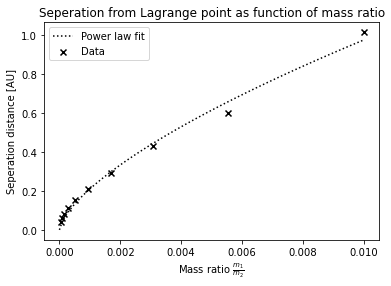

In [20]:
# Linear scale
t = np.linspace(0, 0.01, 100)

plt.scatter(r, s, marker="x", color="k", label="Data")

plt.plot(t, polynomial(t, *coefpl), color="black", linestyle="dotted", label="Power law fit")
plt.xlabel(r'Mass ratio $\frac{m_1}{m_2}$')
plt.ylabel("Seperation distance [AU]")
plt.title("Seperation from Lagrange point as function of mass ratio")
plt.legend()
plt.show()

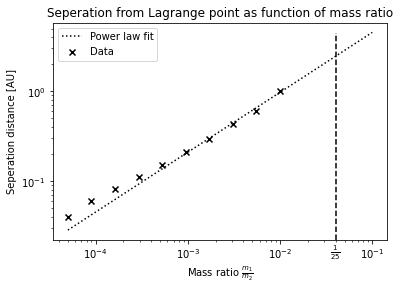

In [21]:
t=np.geomspace(0.5*1e-4, 0.1, 100)

plt.scatter(planet_masses, s, marker="x", color="k", label="Data")

plt.plot(t, polynomial(t, *coefpl), color="black", linestyle="dotted", label="Power law fit")
# plt.plot(t, power(t, *coefp), color="green", linestyle="--", label="power law")
plt.xlabel(r'Mass ratio $\frac{m_1}{m_2}$')
plt.ylabel("Seperation distance [AU]")
plt.title("Seperation from Lagrange point as function of mass ratio")
plt.legend()
plt.axvline(x=1/25, ymax=0.95, ls="--", color="k", label="1/25")
plt.text(0.035, 0.015, r"$\frac{1}{25}$")

plt.yscale("log")
plt.xscale("log")

### Large ratios relation

In [22]:
planet_masses = np.geomspace(1/25, 0.07, 10)

sun_pos = jupiter_mass * np.array([-orb_r, 0, 0])
sun_init_v = jupiter_mass * np.array([0.0,-orb_v,0.0])
sun_mass = 1.0

jupiter_pos = np.array([orb_r, 0.0, 0.0])
jupiter_init_v = np.array([0.0, orb_v, 0])
jupiter_mass = 0.000955

L5_pos = lagrange_evolution(jupiter_pos)
L5_init_v = lagrange_evolution(jupiter_init_v)
L5_trojan_m = 1e-10

seperation_dist = []

for m in planet_masses:
    init_pos = np.array([(m/jupiter_mass) * sun_pos, jupiter_pos, L5_pos])
    init_vel = np.array([(m/jupiter_mass) * sun_init_v, jupiter_init_v, L5_init_v])
    mass = np.array([sun_mass, m, L5_trojan_m])
    
    tEnd = real_time(11.78*40)*10
    
    positions = integrator(init_pos, init_vel, mass, tEnd, dt=0.01)

    seperation_dist.append([m, seperation(positions)])

seperation_dist = np.array(seperation_dist)

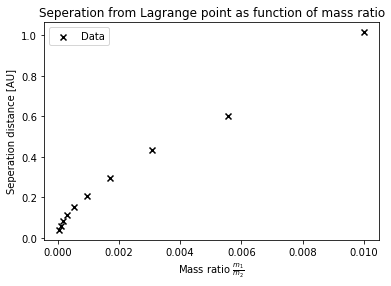

In [23]:
# Linear scale
t = np.linspace(0.04, 0.1, 100)

plt.scatter(r, s, marker="x", color="k", label="Data")

# plt.plot(t, linear(t, *coefl), color="red", linestyle="dotted", label="Quadratic fit")
plt.xlabel(r'Mass ratio $\frac{m_1}{m_2}$')
plt.ylabel("Seperation distance [AU]")
plt.title("Seperation from Lagrange point as function of mass ratio")
plt.legend()
plt.show()

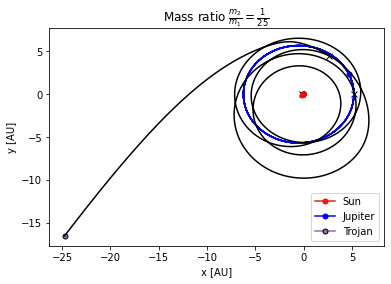

In [24]:
planet_masses = np.geomspace(0.5*1e-4, 1/25, 10)

r = 1/25

sun_pos = r * np.array([-orb_r, 0, 0])
sun_init_v = r * np.array([0.0,-orb_v,0.0])
sun_mass = 1.0

jupiter_pos = np.array([orb_r, 0.0, 0.0])
jupiter_init_v = np.array([0.0, orb_v, 0])
jupiter_mass = r

L5_pos = lagrange_evolution(jupiter_pos)
L5_init_v = lagrange_evolution(jupiter_init_v)
L5_trojan_m = 1e-10


init_pos = np.array([sun_pos, jupiter_pos, L5_pos])
init_vel = np.array([sun_init_v, jupiter_init_v, L5_init_v])
mass = np.array([sun_mass, jupiter_mass, L5_trojan_m])
    
tEnd = real_time(11.78*40)*6
    
positions = integrator(init_pos, init_vel, mass, tEnd, dt=0.01)
    
sun = positions[:,0]
jupiter = positions[:,1]
trojan = positions[:,2]


plt.plot(sun[0,0], sun[0,1], marker="x", markeredgecolor="k")
plt.plot(jupiter[0,0], jupiter[0,1], marker="x", markeredgecolor="k")
plt.plot(trojan[0,0], trojan[0,1], marker="x", markeredgecolor="k")

plt.plot(sun[-1,0], sun[-1,1], marker="o", markersize=5, markeredgecolor="r", label = "Sun")
plt.plot(jupiter[-1,0], jupiter[-1,1], marker="o", markersize=5, color="b", label = "Jupiter")
plt.plot(trojan[-1,0], trojan[-1,1], marker="o", markersize=5, markeredgecolor="black", label = "Trojan")

plt.plot(sun[:,0], sun[:,1], color="r")
plt.plot(jupiter[:,0], jupiter[:,1], color="b")
plt.plot(trojan[:,0], trojan[:,1], color="black")


plt.title(r"Mass ratio $\frac{m_2}{m_1}=\frac{1}{25}$")
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")
plt.legend(loc="lower right")



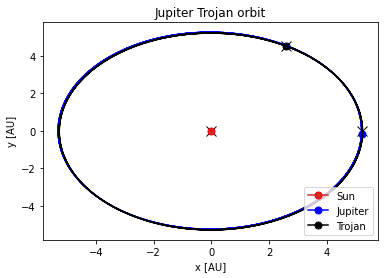

In [25]:
planet_masses = np.geomspace(0.5*1e-4, 1/25, 10)

r = 1e-3

sun_pos = r * np.array([-orb_r, 0, 0])
sun_init_v = r * np.array([0.0,-orb_v,0.0])
sun_mass = 1.0

jupiter_pos = np.array([orb_r, 0.0, 0.0])
jupiter_init_v = np.array([0.0, orb_v, 0])
jupiter_mass = r

L5_pos = lagrange_evolution(jupiter_pos)
L5_init_v = lagrange_evolution(jupiter_init_v)
L5_trojan_m = 1e-10


init_pos = np.array([sun_pos, jupiter_pos, L5_pos])
init_vel = np.array([sun_init_v, jupiter_init_v, L5_init_v])
mass = np.array([sun_mass, jupiter_mass, L5_trojan_m])
    
tEnd = real_time(11.82*40)*3
    
positions = integrator(init_pos, init_vel, mass, tEnd, dt=0.01)

    
sun = positions[:,0]
jupiter = positions[:,1]
trojan = positions[:,2]


plt.plot(sun[0,0], sun[0,1], marker="x", markersize=10, markeredgecolor="k")
plt.plot(jupiter[0,0], jupiter[0,1], marker="x", markersize=10, markeredgecolor="k")
plt.plot(trojan[0,0], trojan[0,1], marker="x", markersize=10, markeredgecolor="k")

plt.plot(sun[-1,0], sun[-1,1], marker="o", markersize=7, markeredgecolor="r", label = "Sun")
plt.plot(jupiter[-1,0], jupiter[-1,1], marker="o", markersize=7, color="b", label = "Jupiter")
plt.plot(trojan[-1,0], trojan[-1,1], marker="o", markersize=7, color="black", label = "Trojan")

plt.plot(sun[:,0], sun[:,1], color="r")
plt.plot(jupiter[:,0], jupiter[:,1], color="b")
plt.plot(trojan[:,0], trojan[:,1], color="k")


plt.title(r"Jupiter Trojan orbit")
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")
plt.legend(loc="lower right")



10.418020496351053


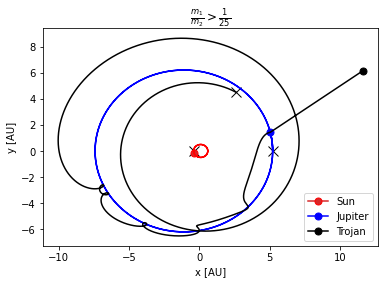

In [26]:
planet_masses = np.geomspace(0.5*1e-4, 1/25, 10)

r = 2/25

sun_pos = r * np.array([-orb_r, 0, 0])
sun_init_v = r * np.array([0.0,-orb_v,0.0])
sun_mass = 1.0

jupiter_pos = np.array([orb_r, 0.0, 0.0])
jupiter_init_v = np.array([0.0, orb_v, 0])
jupiter_mass = r

L5_pos = lagrange_evolution(jupiter_pos)
L5_init_v = lagrange_evolution(jupiter_init_v)
L5_trojan_m = 1e-10


init_pos = np.array([sun_pos, jupiter_pos, L5_pos])
init_vel = np.array([sun_init_v, jupiter_init_v, L5_init_v])
mass = np.array([sun_mass, jupiter_mass, L5_trojan_m])
    
tEnd = real_time(11.82*40)*2.89
    
positions = integrator(init_pos, init_vel, mass, tEnd, dt=0.01)

print(seperation(positions))
    
sun = positions[:,0]
jupiter = positions[:,1]
trojan = positions[:,2]


plt.plot(sun[0,0], sun[0,1], marker="x", markersize=10, markeredgecolor="k")
plt.plot(jupiter[0,0], jupiter[0,1], marker="x", markersize=10, markeredgecolor="k")
plt.plot(trojan[0,0], trojan[0,1], marker="x", markersize=10, markeredgecolor="k")

plt.plot(sun[-1,0], sun[-1,1], marker="o", markersize=7, markeredgecolor="r", label = "Sun")
plt.plot(jupiter[-1,0], jupiter[-1,1], marker="o", markersize=7, color="b", label = "Jupiter")
plt.plot(trojan[-1,0], trojan[-1,1], marker="o", markersize=7, color="black", label = "Trojan")

plt.plot(sun[:,0], sun[:,1], color="r")
plt.plot(jupiter[:,0], jupiter[:,1], color="b")
plt.plot(trojan[:,0], trojan[:,1], color="k")


plt.title(r"$\frac{m_1}{m_2} > \frac{1}{25}$")
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")
plt.legend(loc="lower right")

